# Lec04. Image Augmentation(이미지 증강) -> fashion mnist cnn

ref: https://keras.io/api/preprocessing/image/

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation            # FC
from keras.layers import Conv2D, MaxPooling2D,Flatten # CNN

from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint # callback

# ------------------- seed 고정 -----------------------
np.random.seed(1024)
tf.random.set_seed(1024)

In [8]:
# 이미지 증강
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [9]:
from keras.datasets import fashion_mnist

In [10]:
# colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 이미지 증강 위해서는 3단 구조 구성해야 함.

<pre>
main_directory/           ---------- 최상위 폴더
...class_a/               ----------  ㄴ 서브폴더 : 븐류클래스
......a_image_1.jpg       ----------    ㄴ 관련 이미지
......a_image_2.jpg       ----------    ㄴ 관련 이미지
...class_b/
......b_image_1.jpg
......b_image_2.jpg

# data

In [11]:
# api에는 tensorflow.keras 쓰도록 되어있지만 keras가 떨어져 나와서 tensorflow 없어도 됨.
from keras.datasets import mnist # toydataset. 누구나 거쳐가는 데이터

In [12]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() # keras에서 load_data는 train, test set 나눠서 한다.

4431872/4422102 [==============================] - 0s 0us/step


In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [14]:
pd.Series(y_train).value_counts()

9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
dtype: int64

# EDA

(60000, 28, 28)


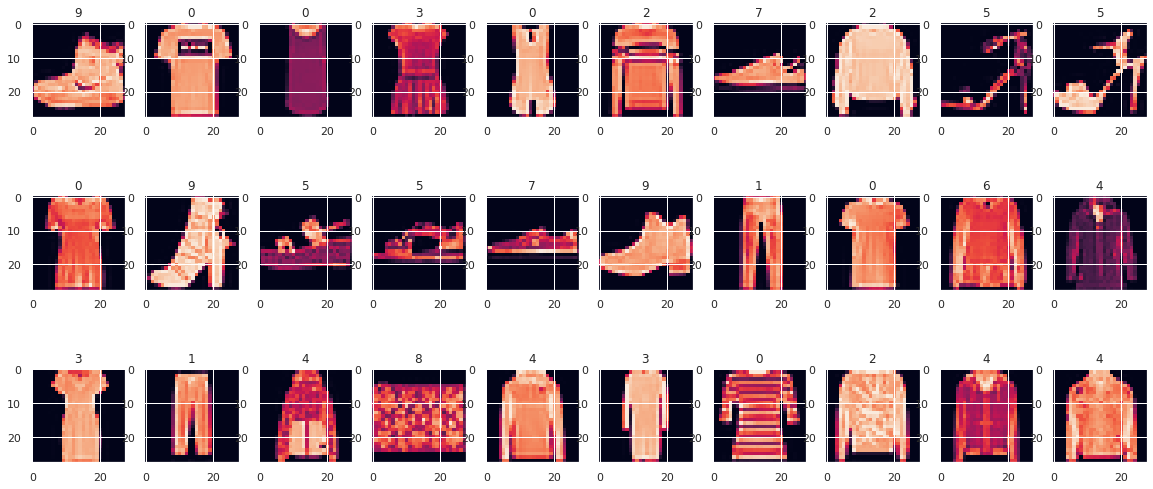

In [15]:
# import matplotlib.pyplot as plt
p, axes = plt.subplots(3,10,figsize=(20,9))

print(X_train.shape)
X_train.shape[0]
for i in range(30): # range(X_train[:30].shape[0]) 해도 된다.
    row=i//10
    col=i%10
    axes[row,col].imshow(X_train[i])#, cmap=plt.get_cmap('gray'))
    axes[row,col].set_title(y_train[i])
plt.show()

In [16]:
label = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# X데이터 가공

* <font color=red><b>CNN 모델 : shape(장수,H,W,컬러)</b></font>

In [17]:
X_train_img=X_train.reshape(-1,28,28,1)
X_test_img=X_test.reshape(-1,28,28,1)

In [18]:
X_train_img.shape

(60000, 28, 28, 1)

In [19]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [20]:
# X_train = X_train.reshape(X_train.shape[0], 784) # 784=28*28
# X_test = X_test.reshape(X_test.shape[0], 784) # 784=28*28

In [21]:
# 정규화는 밑에서 진행 !!!!! 
# X_train_scaled=X_train_img/255.0
# X_test_scaled=X_test_img/255.0

# y label 평준화
y_label : integers in range 0-9

<pre>
* ML : arr.LabelEncoder() 글->숫, arr.OneHotEncoder() 1 0 0 0 ... df.get_dummies() 결측처리, 글->숫, 원핫

In [22]:
y_train_oh=to_categorical(y=y_train, num_classes=10, dtype='int32') # class 숫자 찍어줘야함
y_test_oh=to_categorical(y=y_test, num_classes=10, dtype='int32')

# CNN Model 구축

In [23]:
INPUT_SHAPE__ = (28,28,1)           # ------------------ 주의주의주의(장수는 관련 없다.)
NUM_CLASS__= 10                     # ------------------ 총 10개로 분류
ACTIVATION__ = "softmax"            # ------------------ 또는 sigmoid
LOSS__ = 'categorical_crossentropy' # ------------------ binary_crossentropy, sparse_crossentropy

model = Sequential([
    # ---------- CNN -------------
    Conv2D(16, kernel_size=(3,3), input_shape=INPUT_SHAPE__, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(16, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),


    # ---------FC(Affine) --------
    Dense(units=128 , activation='relu'),
    Dense(units=10 , activation=ACTIVATION__) # 다중분류 예측(0~9)

])

model.compile(loss=LOSS__ , # logloss라고 써도 된다.
             optimizer='adam',
             metrics='accuracy')

In [24]:
# model.summary()

# 학습 & 평가

<font color=red size=4>callbacks: https://keras.io/api/callbacks/</font>

* Write TensorBoard logs after every batch of training to monitor your metrics  
* <font color=red>Periodically save your model to disk</font>-----------------------------------------------모델 저장  
* <font color=red>Do early stopping</font>------------------------------------------------------------------오버피팅 시 조기 종료  
* Get a view on internal states and statistics of a model during training

In [25]:
EPOCHS__ = 100
BATCH_SIZE__ = 128
PATIENCE__ = 5

In [26]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
MY_CALLBACKS__ = [
    EarlyStopping(patience=PATIENCE__), # 점수 더 좋아질 기미 안 보이면 stop. patience동안 점수 안 좋으면 멈춘다.
    ModelCheckpoint(filepath='./model/mymodel.{epoch:02d}-{val_loss:.4f}.h5', # 이전 epoch보다 현재가 점수 더 좋으면 mydoel_03_.2417.h5
                    monitor='val_loss',        # ------- 어떤 점수를 기준으로 모니터링 할까
                    save_best_olny=True,       # ------- 좋을 때만 저장(?)(best만 저장??)
                    save_weight_only=False)     # ------- False: model+가중치 같이 저장 / 가중치만 알고 모델 구조 모르면 모델 돌릴 수 없다.(잘 알려진 모델은 가중치만 배포하기도. 우리가 만든 모델은 모델까지 배포해야 남들이 쓴다.)
]

In [ ]:
res=model.fit(X_train_scaled,
              y_train_oh,
              epochs=EPOCHS__,
              batch_size=BATCH_SIZE__,   # 128바이트씩 끊어서 읽어라
              validation_split=0.1,      # validation은 epoch 돌 때마다 고정인가요? ㅇㅇ 그래야 역전파 할 때마다 점수 비교해서 가중치 조정할 수 있으니까
              callbacks=MY_CALLBACKS__
                )

In [ ]:
loss_cateforical_crossentropy, metrics_accuracy = model.evaluate(X_test_scaled, y_test_oh) 

# 평가 시각화

In [ ]:
plt.plot(np.arange(len(res.history['loss'])), res.history['loss'], c='red', label='loss')
plt.plot(np.arange(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss')
plt.legend()
plt.show()

In [ ]:
# 빨간 선과 파란 선 벌어져야 오버핏인데 별로 안 벌어진다.
plt.plot(np.arange(len(res.history['accuracy'])), res.history['accuracy'], c='red', label='accuracy')
plt.plot(np.arange(len(res.history['val_accuracy'])), res.history['val_accuracy'], c='blue', label='val_accuracy')
plt.legend()
plt.show()

# 이미지 증강
ref: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator  
ref: https://keras.io/ko/preprocessing/image/

In [ ]:
# 이미지 증강
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [ ]:
# generator=ImageDataGenerator(featurewise_center=False, 
#                              samplewise_center=False,
#                              featurewise_std_normalization=False,
#                              samplewise_std_normalization=False,
#                              zca_whitening=False,
#                              zca_epsilon=1e-06,
#                              rotation_range=0,
#                              width_shift_range=0.0,
#                              height_shift_range=0.0,
#                              brightness_range=None,
#                              shear_range=0.0,
#                              zoom_range=0.0,
#                              channel_shift_range=0.0,
#                              fill_mode='nearest', 
#                              cval=0.0,
#                              horizontal_flip=False, 
#                              vertical_flip=False,
#                              rescale=None,
#                              preprocessing_function=None,
#                              data_format=None,
#                              validation_split=0.0,
#                              dtype=None)

In [ ]:
img_list = image_dataset_from_directory(dir)

## 픽셀을 arr[28][28] 값으로 가지고 있는 경우

In [ ]:
# fit에 X_train_scaled, y_train_oh 태웠다.
X_train_scaled.shape, y_train_oh.shape, X_train_scaled[0].shape, label[np.argmax(y_train_oh[0])] # label에 넣어놨다

### 이미지 보기

#### matplot imshow 이용

In [ ]:
# 1)
import matplotlib.pyplot as plt
plt.imshow(X_train_scaled[0]) # (28,28,1))
plt.title(f"{np.argmax(y_train_of[0])} {label[np.argmax(y_train_oh[0])]}")
plt.show()

#### keras api 사용

In [ ]:
# from PIL import Image
# # from keras.utils.img_to_array
# from keras.preprocesing.image import array_to_img, img_to_array, load_img


# img = array_to_img(X_train_scaled[0])
# array = img_to_array(img)

# Image Generator 만들기

In [ ]:
# 주의 : train data는 다양한 형태로 학습하는 게 맞다. 하지만 test data, val data는 그러면 안 된다.
# 증강 하면 데이터 개수가 많아진다. -> 갑자기 답지 개수 많아짐.

# -----------------train만 증강------------------------
train_datagen = ImageDataGenerator(rescale=1./255,             # 0~255 스케일링
                                    featurewise_center=True,
                                    rotation_range=20,
                                    width_shift_range=0.2,     # width축을 20% 이동 시켜서 사과를 옆으로 두고 이동
                                    height_shift_range=0.2,   # height축을 20% 이동 시켜서 사과를 옆으로 두고 이동
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    )



# -----------------test 증강 XXXXX(색 정규화만)------------------------
test_datagen = ImageDataGenerator(rescale=1./255)             # 0~255 스케일링


# fit
# datagen.fit(x_train)

# fit_generator (fit이랑 동시에)
model.fit_generator(train_datagen.flow(X_train_scaled, y_train_oh, batch_size=32), # rescale 했는데 다시 scaled 된 데이터 넣어도 되나? -> 원래는 이렇게 어레이 딴에서 안 한다. 디렉토리로 넘김.
                                                                                    # 증강 하기 전 거랑 한 파일 안에 코드 다 구겨 넣으려다보니까 이모양 ^^;;;;
                    steps_per_epoch=len(X_train_img) / 32,
                    epochs=10)


* 연습용(fit_generator 원리)

In [ ]:
import time
for e in range(epochs):
    print('Epoch', e)
    batches = 0   # batch count

    for X_batch, y_batch in datagen.flow(X_train_img, y_train_oh, batch_size=32):
        model.fit(X_batch, y_batch)
        batches += 1
        if batches >= len(X_train_img) / 32:  # ex. 사진 총 320장이면 batch size를 32로 했을 때 총 증강된 이미지는 10장 / batch size 줄이면 이미지 증강 더 많이 시킬 수있다.
            break                         # 학습은 한 사진 당 증강된 이미지 * epochs만큼 학습 이루어진다.
        time.sleep(500)                   # 500 마이크로 세컨즈만큼 천천히 만들게

## 폴더의 이미지를 증강시킬 경우